In [1]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
model = VGG16(weights='imagenet', include_top = False)

Using TensorFlow backend.


In [2]:
train_data_dir = '../data/interim/170308/labelled/train'
test_data_dir = '../data/interim/170308/labelled/test'
#bottleneck_features_train_path = "../data/interim/170308/bottleneck_features_train.npy"
#bottleneck_features_test_path = "../data/interim/170308/bottleneck_features_test.npy"
nb_train_samples = 390
nb_test_samples = 205

In [3]:
default_size=224
datagen = ImageDataGenerator(rescale=1., featurewise_center=True)
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3) #deails with VGG normalisation

generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(default_size, default_size),
            batch_size=32,
            class_mode=None,
            shuffle=False)
bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
#np.save(open(bottleneck_features_train_path, 'w'), bottleneck_features_train, allow_pickle=False)

generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(default_size, default_size),
        batch_size=32,
        class_mode=None,
        shuffle=False)
bottleneck_features_test = model.predict_generator(generator, nb_test_samples)
#np.save(open(bottleneck_features_test_path, 'w'), bottleneck_features_test, allow_pickle=False)

Found 390 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [4]:
generator.class_indices

{'not_sign': 0, 'sign': 1}

In [5]:
bottleneck_features_test.shape

(205, 7, 7, 512)

# Run NN features through a SVM (linear)

In [6]:
#reshape data
X_train = bottleneck_features_train.reshape(nb_train_samples, 7*7*512)
y_train = np.array([0] * 90 + [1] * 300)
X_test = bottleneck_features_test.reshape(nb_test_samples, 7*7*512)
y_test = np.array([0] * 40 + [1] * 165)

In [7]:
# run one SVM
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC(kernel="linear", C=1)
clf.fit(X_train, y_train)
y = clf.predict(X_test)
cm = confusion_matrix(y_test, y)                         
n_neg = np.sum(y_test==0)
n_pos = np.sum(y_test==1)
n = len(y_test)
print("accuracy = %2.5f percent" % clf.score(X_test, y_test))
print("number negatives in y_test: %d or %2.0f percent" % (n_neg, float(n_neg)/float(n)*100))
print("number positives in y_test: %d or %2.0f percent" % (n_pos, float(n_pos)/n * 100))
print("True positives: {}".format(float(cm[1,1]) / n_pos))                        
print("False negatives: {}".format(float(cm[1,0]) / n_pos))                       
print("True negatives: {}".format(float(cm[0,0]) / n_neg))                        
print("False positives: {}".format(float(cm[0,1]) / n_neg)) 

accuracy = 0.99024 percent
number negatives in y_test: 40 or 20 percent
number positives in y_test: 165 or 80 percent
True positives: 1.0
False negatives: 0.0
True negatives: 0.95
False positives: 0.05


In [7]:
# save model (this is good )
import pickle
pickle.dump( clf, open( "../models/vgg_svm_lin_model.p", "wb" ) )

/home/ubuntu/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


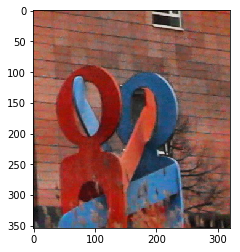

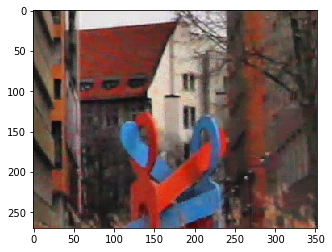

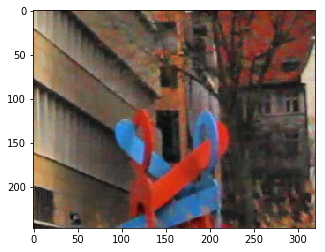

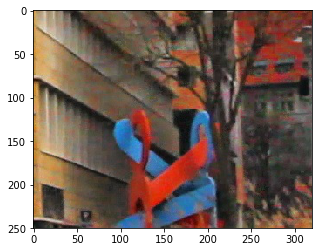

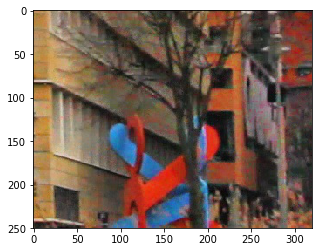

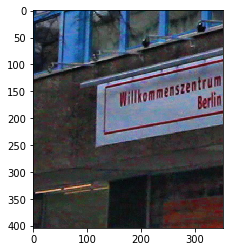

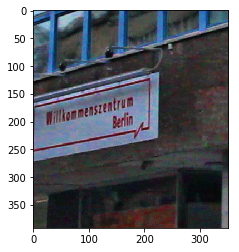

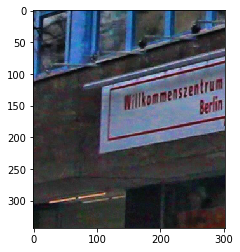

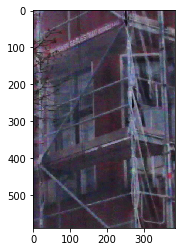

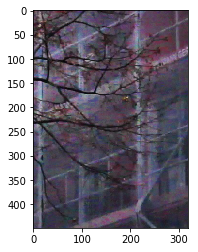

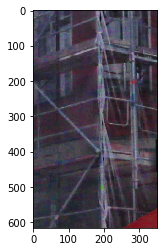

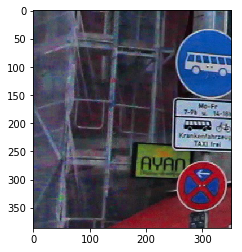

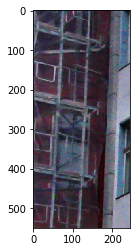

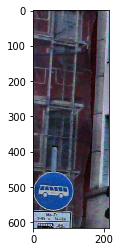

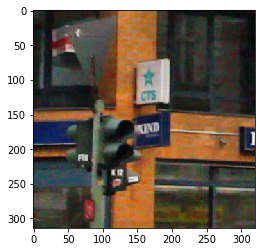

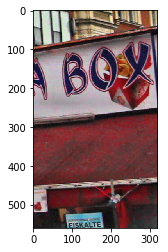

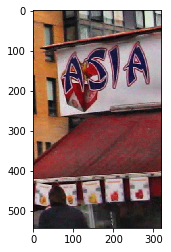

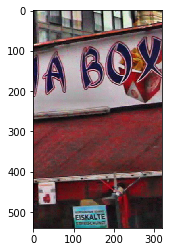

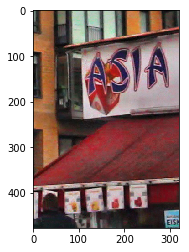

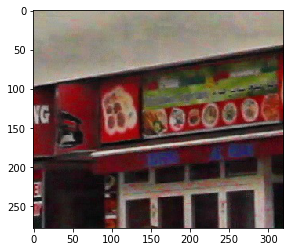

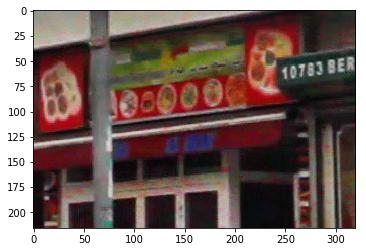

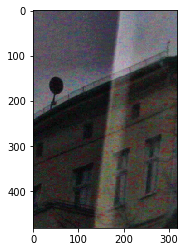

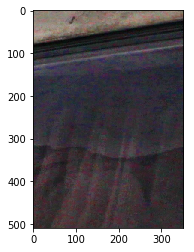

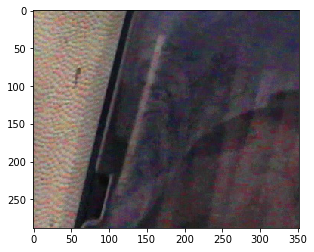

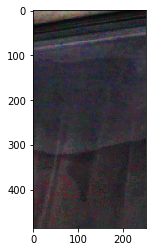

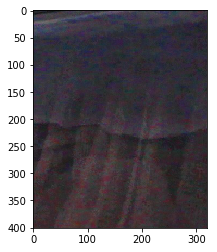

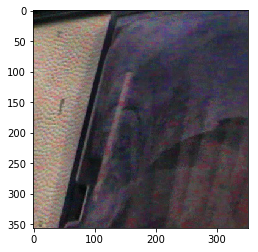

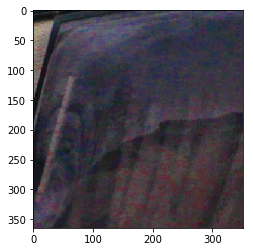

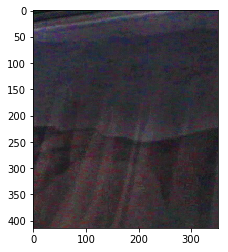

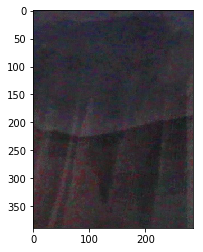

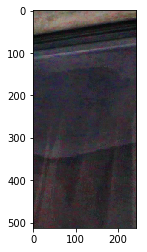

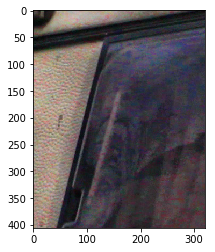

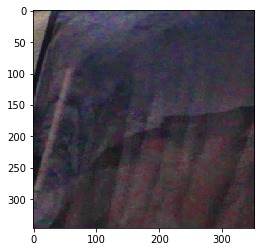

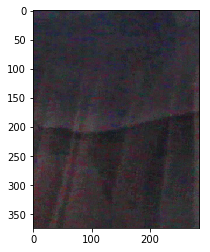

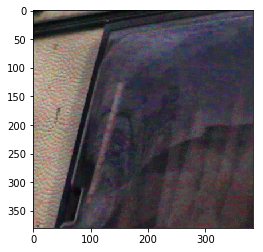

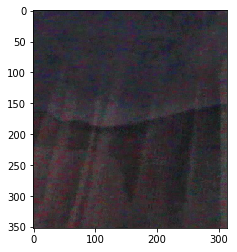

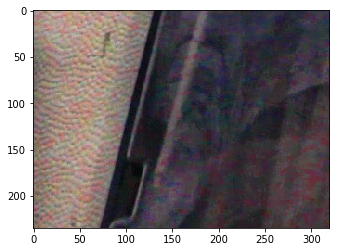

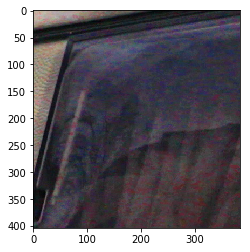

In [9]:
#check not_sign
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os.path import join as pj
%matplotlib inline
n_to_draw = 100
n_drawn = 0
for i, f in zip(y, generator.filenames):
    if i==0:
        fig = plt.figure()
        plt.imshow(mpimg.imread(pj(test_data_dir, f)))
        n_drawn += 1
        if n_drawn >= n_to_draw:
            break    

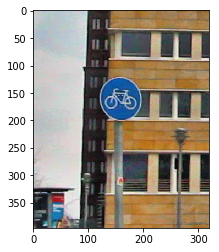

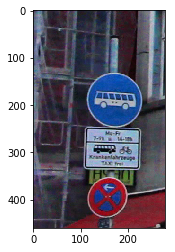

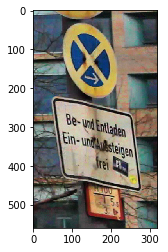

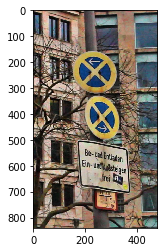

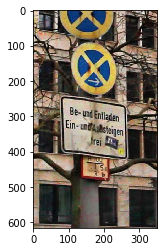

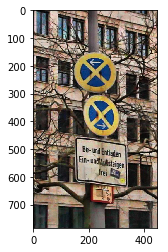

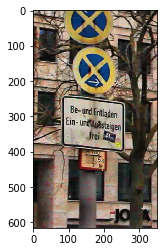

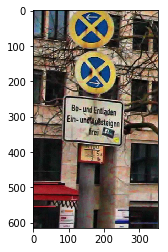

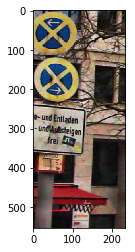

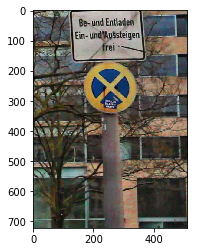

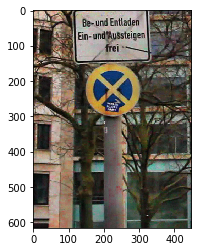

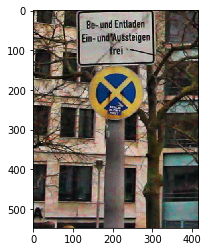

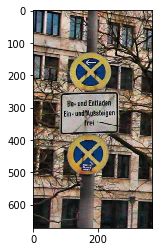

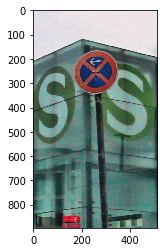

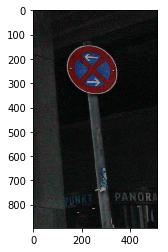

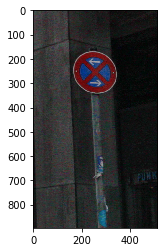

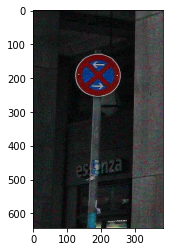

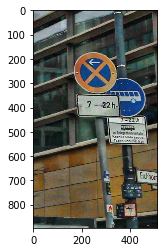

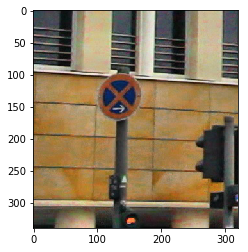

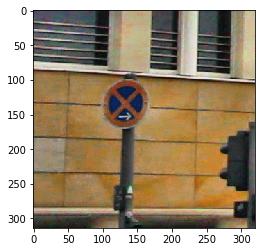

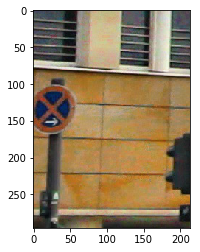

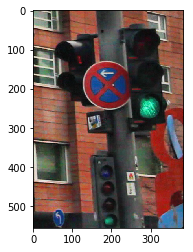

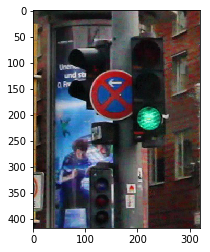

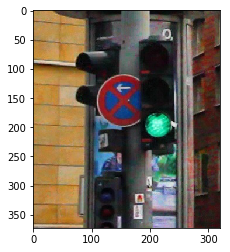

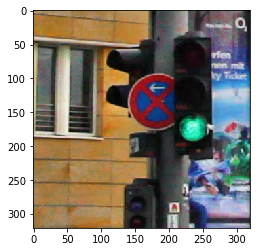

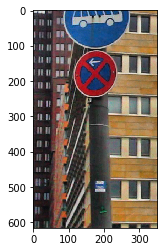

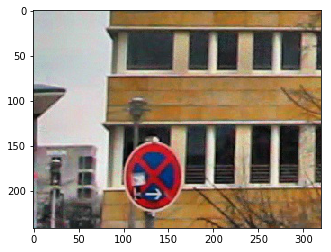

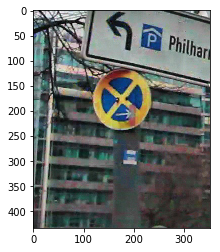

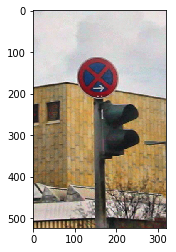

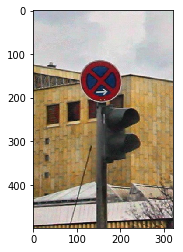

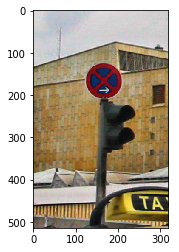

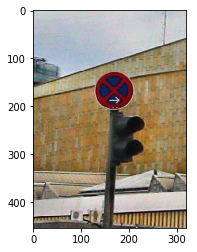

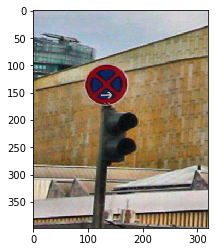

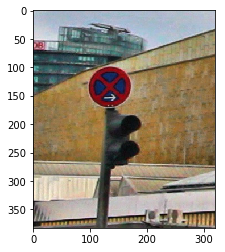

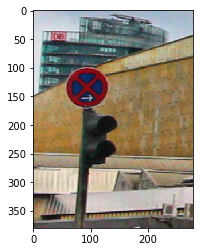

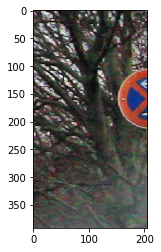

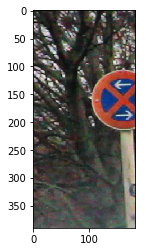

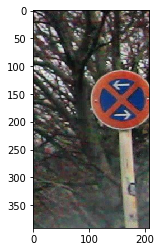

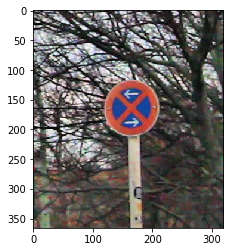

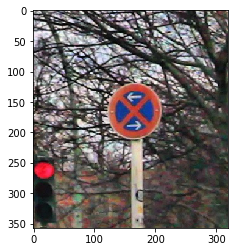

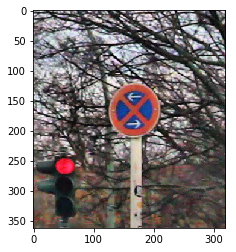

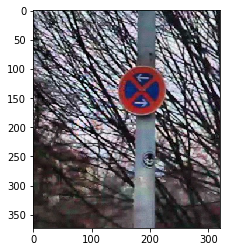

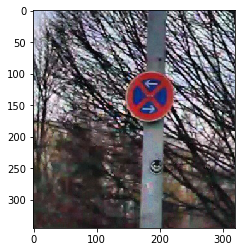

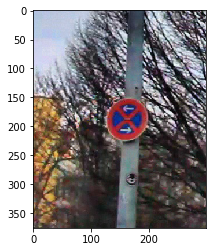

In [ ]:
#check sign
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os.path import join as pj
%matplotlib inline
n_to_draw = 100
n_drawn = 0
for i, f in zip(y, generator.filenames):
    if i==1:
        fig = plt.figure()
        plt.imshow(mpimg.imread(pj(test_data_dir, f)))
        n_drawn += 1
        if n_drawn >= n_to_draw:
            break    

In [8]:
# scan regularisration param space and inspect ROC curves
from sklearn.metrics import roc_curve, auc
from collections import OrderedDict
                                                                               
cs = np.logspace(-10, 10, num=11) #regularisation parameters                     
tn=[]; fn=[]; fp=[]; tp=[]; #to store % true/false negatives/positives 
fpr = OrderedDict()
tpr = OrderedDict()
roc_auc = OrderedDict()
for c in cs:                                                                   
    
    clf.set_params(C=c)                                                       
    clf.fit(X_train, y_train)                                                  
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr[c], tpr[c], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc[c] = auc(fpr[c], tpr[c])
    
    cm = confusion_matrix(y_test, clf.predict(X_test))                         
    tp.append(float(cm[1,1]) / n_pos)                                                 
    fn.append(float(cm[1,0]) / n_pos)                                                 
    tn.append(float(cm[0,0]) / n_neg)                                                 
    fp.append(float(cm[0,1]) / n_neg)    

#import pickle
#pickle.dump( fpr, open( "svm_lin_vgg_fpr.p", "wb" ) )
#pickle.dump( tpr, open( "svm_lin_vgg_tpr.p", "wb" ) )

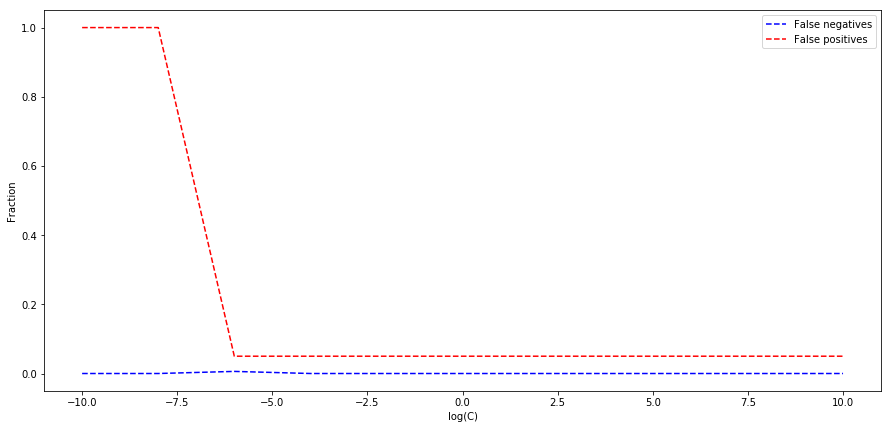

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
#plt.plot(np.log10(cs), tp, 'b', label='True positives')                        
plt.plot(np.log10(cs), fn, 'b--', label='False negatives')                     
#plt.plot(np.log10(cs), tn, 'r', label='True negatives')                        
plt.plot(np.log10(cs), fp, 'r--', label='False positives')                     
plt.xlabel('log(C)')                                                           
plt.ylabel('Fraction')                                                         
plt.legend()  

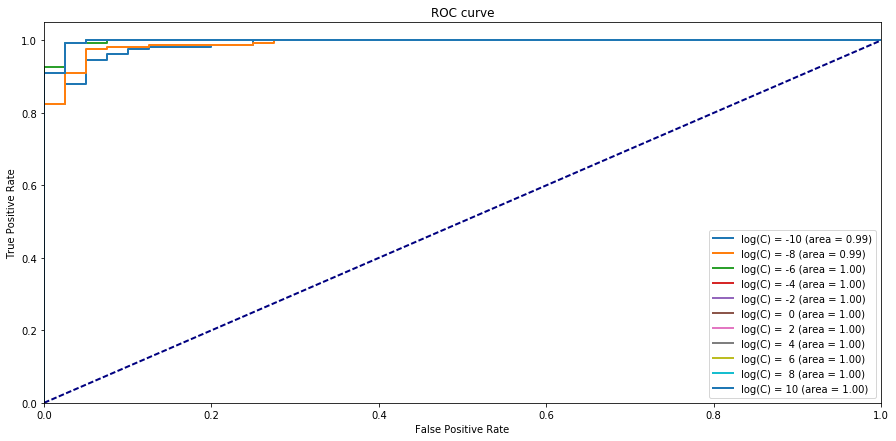

In [10]:
plt.figure(figsize=(15,7))
lw = 2
for key in fpr.keys():
    label = 'log(C) = %2.0f (area = %0.2f)' % (np.log10(key), roc_auc[key])
    plt.plot(fpr[key], tpr[key], lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Run NN features through a SVM (rbf)

In [ ]:
# scan regularisration param space and inspect ROC curves
from sklearn.metrics import roc_curve, auc
from collections import OrderedDict

clf = SVC(kernel="rbf", C=1)                                                                               
cs = np.logspace(-10, 10, num=11) #regularisation parameters                     
tn=[]; fn=[]; fp=[]; tp=[]; #to store % true/false negatives/positives 
fpr = OrderedDict()
tpr = OrderedDict()
roc_auc = OrderedDict()
for c in cs:                                                                   
    
    clf.set_params(C=c)                                                       
    clf.fit(X_train, y_train)                                                  
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr[c], tpr[c], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc[c] = auc(fpr[c], tpr[c])
    
    cm = confusion_matrix(y_test, clf.predict(X_test))                         
    tp.append(float(cm[1,1]) / n_pos)                                                 
    fn.append(float(cm[1,0]) / n_pos)                                                 
    tn.append(float(cm[0,0]) / n_neg)                                                 
    fp.append(float(cm[0,1]) / n_neg) 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(np.log10(cs), tp, 'b', label='True positives')                        
plt.plot(np.log10(cs), fn, 'b--', label='False negatives')                     
#plt.plot(np.log10(cs), tn, 'r', label='True negatives')                        
plt.plot(np.log10(cs), fp, 'r--', label='False positives')                     
plt.xlabel('log(C)')                                                           
plt.ylabel('Fraction')                                                         
plt.legend()  

In [ ]:
plt.figure(figsize=(15,7))
lw = 2
for key in fpr.keys():
    label = 'log(C) = %2.0f (area = %0.2f)' % (np.log10(key), roc_auc[key])
    plt.plot(fpr[key], tpr[key], lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Old SVM code to get model from paramater space scan

In [ ]:
import numpy as np
train_data = np.load(open('bottleneck_features_train.npy'))
train_labels = np.array([0] * 90 + [1] * 300)
validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 40 + [1] * 165)

In [ ]:
from sklearn.svm import SVC
train_data = train_data.reshape(390, 7*7*512)
clf = SVC(kernel="linear")
clf.fit(train_data, train_labels)  

In [ ]:
validation_data = validation_data.reshape(205, 7*7*512)
score = clf.score(validation_data, validation_labels)
print("score: %0.4f" % score)

In [ ]:
>>> from sklearn import svm
>>> from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
>>> svr = svm.SVC(kernel="linear")
>>> clf = GridSearchCV(svr, parameters)
>>> clf.fit(train_data, train_labels)

In [ ]:
clf.best_params_

In [ ]:
clf.cv_results_

In [ ]:
score = clf.score(validation_data, validation_labels)
print("score: %0.4f" % score)

In [ ]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
>>> svr = svm.SVC(kernel="rbf")
>>> clf_ = GridSearchCV(svr, parameters, n_jobs=-1)
>>> clf_.fit(train_data, train_labels)

In [ ]:
score = clf.score(validation_data, validation_labels)
print("score: %0.4f" % score)